In [1]:
# Importing necessary libraries for Graph and GraphData classes
from rdkit import Chem
from rdkit.Chem import rdmolops
import numpy as np
import pandas as pd
import torch.nn as nn
import torch 
from torch.utils.data import Dataset
from pathlib import Path
from torch.utils.data import DataLoader, SubsetRandomSampler

# Note: MolDG library is mentioned in your context, but it's not a standard library.
# If it's a custom library or part of another package, make sure to import it correctly.
# For example:
# from some_package import MolDG  # Replace 'some_package' with the actual package name


class Graph:
    def __init__(
        self, molecule_smiles: str,
        node_vec_len: int,
        max_atoms: int = None
      ):
        # Store properties
        self.smiles = molecule_smiles
        self.node_vec_len = node_vec_len
        self.max_atoms = max_atoms

        # Call helper function to convert SMILES to RDKit mol
        self.smiles_to_mol()

        # If valid mol is created, generate a graph of the mol
        if self.mol is not None:
            self.smiles_to_graph()

    def smiles_to_mol(self):
        # Use MolFromSmiles from RDKit to get molecule object
        mol = Chem.MolFromSmiles(self.smiles)
        
        # If a valid mol is not returned, set mol as None and exit
        if mol is None:
            self.mol = None
            return

        # Add hydrogens to molecule
        self.mol = Chem.AddHs(mol)

    def smiles_to_graph(self):
        # Get list of atoms in molecule
        atoms = self.mol.GetAtoms()

        # If max_atoms is not provided, max_atoms is equal to maximum number 
        # of atoms in this molecule. 
        if self.max_atoms is None:
            n_atoms = len(list(atoms))
        else:
            n_atoms = self.max_atoms

        # Create empty node matrix
        node_mat = np.zeros((n_atoms, self.node_vec_len))

        # Iterate over atoms and add to node matrix
        for atom in atoms:
            # Get atom index and atomic number
            atom_index = atom.GetIdx()
            atom_no = atom.GetAtomicNum()

            # Assign to node matrix
            node_mat[atom_index, atom_no] = 1

        # Get adjacency matrix using RDKit
        adj_mat = rdmolops.GetAdjacencyMatrix(self.mol)
        self.std_adj_mat = np.copy(adj_mat)

        # Get distance matrix using RDKit
        dist_mat = molDG.GetMoleculeBoundsMatrix(self.mol)
        dist_mat[dist_mat == 0.] = 1

        # Get modified adjacency matrix with inverse bond lengths
        adj_mat = adj_mat * (1 / dist_mat)

        # Pad the adjacency matrix with 0s
        dim_add = n_atoms - adj_mat.shape[0]
        adj_mat = np.pad(
            adj_mat, pad_width=((0, dim_add), (0, dim_add)), mode="constant"
        )

        # Add an identity matrix to adjacency matrix
        # This will make an atom its own neighbor
        adj_mat = adj_mat + np.eye(n_atoms)

        # Save both matrices
        self.node_mat = node_mat
        self.adj_mat = adj_mat

In [2]:
class GraphData(Dataset):
    def __init__(self, dataset_path: str, node_vec_len: int, max_atoms: int):
        # Save attributes
        self.node_vec_len = node_vec_len
        self.max_atoms = max_atoms

        # Open dataset file
        df = pd.read_csv(dataset_path)

        # Create lists
        self.indices = df.index.to_list()
        self.smiles = df["smiles"].to_list()
        self.outputs = df["measured log solubility in mols per litre"].to_list()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i: int):
        # Get smile
        smile = self.smiles[i]

        # Create MolGraph object using the Graph abstraction
        mol = Graph(smile, self.node_vec_len, self.max_atoms)

        # Get node and adjacency matrices
        node_mat = torch.Tensor(mol.node_mat)
        adj_mat = torch.Tensor(mol.adj_mat)

        # Get output
        output = torch.Tensor([self.outputs[i]])

        return (node_mat, adj_mat), output, smile

In [3]:
def collate_graph_dataset(dataset: Dataset):
    # Create empty lists of node and adjacency matrices, outputs, and smiles
    node_mats = []
    adj_mats = []
    outputs = []
    smiles = []
    
    # Iterate over list and assign each component to the correct list
    for i in range(len(dataset)):
        (node_mat,adj_mat), output, smile = dataset[i]
        node_mats.append(node_mat)
        adj_mats.append(adj_mat)
        outputs.append(output)
        smiles.append(smile)
    
        
    # Create tensors
    node_mats_tensor = torch.cat(node_mats, dim=0)
    adj_mats_tensor = torch.cat(adj_mats, dim=0)
    outputs_tensor = torch.stack(outputs, dim=0)
    
    # Return tensors
    return (node_mats_tensor, adj_mats_tensor), outputs_tensor, smiles

In [4]:
class ConvolutionLayer(nn.Module):
    def __init__(self, node_in_len: int, node_out_len: int):
        # Call constructor of base class
        super().__init__()

        # Create linear layer for node matrix
        self.conv_linear = nn.Linear(node_in_len, node_out_len)

        # Create activation function
        self.conv_activation = nn.LeakyReLU()

    def forward(self, node_mat, adj_mat):
        # Calculate number of neighbors
        n_neighbors = adj_mat.sum(dim=-1, keepdims=True)
        # Create identity tensor
        self.idx_mat = torch.eye(
            adj_mat.shape[-2], adj_mat.shape[-1], device=n_neighbors.device
        )
        # Add new (batch) dimension and expand
        #idx_mat = self.idx_mat.unsqueeze(0).expand(*adj_mat.shape) old code 
        #fixed code:
        idx_mat = self.idx_mat.unsqueeze(0).expand(adj_mat.shape[0], *self.idx_mat.shape)
        # Get inverse degree matrix
        inv_degree_mat = torch.mul(idx_mat, 1 / n_neighbors)

        # Perform matrix multiplication: D^(-1)AN
        node_fea = torch.bmm(inv_degree_mat, adj_mat)
        node_fea = torch.bmm(node_fea, node_mat)

        # Perform linear transformation to node features 
        # (multiplication with W)
        node_fea = self.conv_linear(node_fea)

        # Apply activation
        node_fea = self.conv_activation(node_fea)

        return node_fea

In [5]:
class PoolingLayer(nn.Module):
    def __init__(self):
        # Call constructor of base class
        super().__init__()

    def forward(self, node_fea):
        # Pool the node matrix
        pooled_node_fea = node_fea.mean(dim=1)
        return pooled_node_fea
        

In [6]:
class ChemGCN(nn.Module):
    def __init__(
        self,
        node_vec_len: int,
        node_fea_len: int,
        hidden_fea_len: int,
        n_conv: int,
        n_hidden: int,
        n_outputs: int,
        p_dropout: float = 0.0,
    ):
        # Call constructor of base class
        super().__init__()

        # Define layers
        # Initial transformation from node matrix to node features
        self.init_transform = nn.Linear(node_vec_len, node_fea_len)

        # Convolution layers
        self.conv_layers = nn.ModuleList(
            [
                ConvolutionLayer(
                    node_in_len=node_fea_len,
                    node_out_len=node_fea_len,
                )
                for i in range(n_conv)
            ]
        )

        # Pool convolution outputs
        self.pooling = PoolingLayer()
        pooled_node_fea_len = node_fea_len

        # Pooling activation
        self.pooling_activation = nn.LeakyReLU()

        # From pooled vector to hidden layers
        self.pooled_to_hidden = nn.Linear(pooled_node_fea_len, hidden_fea_len)

        # Hidden layer
        self.hidden_layer = nn.Linear(hidden_fea_len, hidden_fea_len)

        # Hidden layer activation function
        self.hidden_activation = nn.LeakyReLU()

        # Hidden layer dropout
        self.dropout = nn.Dropout(p=p_dropout)

        # If hidden layers more than 1, add more hidden layers
        self.n_hidden = n_hidden
        if self.n_hidden > 1:
            self.hidden_layers = nn.ModuleList(
                [self.hidden_layer for _ in range(n_hidden - 1)]
            )
            self.hidden_activation_layers = nn.ModuleList(
                [self.hidden_activation for _ in range(n_hidden - 1)]
            )
            self.hidden_dropout_layers = nn.ModuleList(
                [self.dropout for _ in range(n_hidden - 1)]
            )

        # Final layer going to the output
        self.hidden_to_output = nn.Linear(hidden_fea_len, n_outputs)

    def forward(self, node_mat, adj_mat):
        # Perform initial transform on node_mat
        node_fea = self.init_transform(node_mat)

        # Perform convolutions
        for conv in self.conv_layers:
            node_fea = conv(node_fea, adj_mat)

        # Perform pooling
        pooled_node_fea = self.pooling(node_fea)
        pooled_node_fea = self.pooling_activation(pooled_node_fea)

        # First hidden layer
        hidden_node_fea = self.pooled_to_hidden(pooled_node_fea)
        hidden_node_fea = self.hidden_activation(hidden_node_fea)
        hidden_node_fea = self.dropout(hidden_node_fea)

        # Subsequent hidden layers
        if self.n_hidden > 1:
            for i in range(self.n_hidden - 1):
                hidden_node_fea = self.hidden_layers[i](hidden_node_fea)
                hidden_node_fea = self.hidden_activation_layers[i](hidden_node_fea)
                hidden_node_fea = self.hidden_dropout_layers[i](hidden_node_fea)

        # Output
        out = self.hidden_to_output(hidden_node_fea)

        return out

In [7]:
class Standardizer:
    def __init__(self, X):
        self.mean = torch.mean(X)
        self.std = torch.std(X)

    def standardize(self, X):
        Z = (X - self.mean) / (self.std)
        return Z

    def restore(self, Z):
        X = self.mean + Z * self.std
        return X

    def state(self):
        return {"mean": self.mean, "std": self.std}

    def load(self, state):
        self.mean = state["mean"]
        self.std = state["std"]

In [8]:
def train_model(
    epoch,
    model,
    training_dataloader,
    optimizer,
    loss_fn,
    standardizer,
    use_GPU,
    max_atoms,
    node_vec_len,
):
    # Create variables to store losses and error
    avg_loss = 0
    avg_mae = 0
    count = 0

    # Switch model to train mode
    model.train()

    # Go over each batch in the dataloader
    for i, dataset in enumerate(training_dataloader):
        # Unpack data
        node_mat = dataset[0][0]
        adj_mat = dataset[0][1]
        output = dataset[1]

        # Reshape inputs
        first_dim = int((torch.numel(node_mat)) / (max_atoms * node_vec_len))
        node_mat = node_mat.reshape(first_dim, max_atoms, node_vec_len)
        adj_mat = adj_mat.reshape(first_dim, max_atoms, max_atoms)

        # Standardize output
        output_std = standardizer.standardize(output)

        # Package inputs and outputs; check if GPU is enabled
        if use_GPU:
            nn_input = (node_mat.cuda(), adj_mat.cuda())
            nn_output = output_std.cuda()
        else:
            nn_input = (node_mat, adj_mat)
            nn_output = output_std

        # Compute output from network
        nn_prediction = model(*nn_input)

        # Calculate loss
        loss = loss_fn(nn_output, nn_prediction)
        avg_loss += loss

        # Calculate MAE
        prediction = standardizer.restore(nn_prediction.detach().cpu())
        mae = mean_absolute_error(output, prediction)
        avg_mae += mae

        # Set zero gradients for all tensors
        optimizer.zero_grad()

        # Do backward prop
        loss.backward()

        # Update optimizer parameters
        optimizer.step()

        # Increase count
        count += 1

    # Calculate avg loss and MAE
    avg_loss = avg_loss / count
    avg_mae = avg_mae / count

    # Print stats
    print(
        "Epoch: [{0}]\tTraining Loss: [{1:.2f}]\tTraining MAE: [{2:.2f}]"\
           .format(
                    epoch, avg_loss, avg_mae
           )
    )

    # Return loss and MAE
    return avg_loss, avg_mae

In [9]:
def test_model(model, test_loader, loss_fn, standardizer, use_GPU, max_atoms, node_vec_len):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    total_mae = 0
    n_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for data in test_loader:
            # Unpack the data
            (node_mat, adj_mat), targets, _ = data

            # Transfer to GPU if available
            if use_GPU:
                node_mat = node_mat.cuda()
                adj_mat = adj_mat.cuda()
                targets = targets.cuda()

            # Forward pass
            outputs = model(node_mat, adj_mat)

            # Calculate loss
            loss = loss_fn(outputs, targets)
            test_loss += loss.item()

            # Calculate MAE
            mae = torch.mean(torch.abs(standardizer.restore(outputs) - standardizer.restore(targets)))
            total_mae += mae.item()

            # Update the number of samples processed
            n_samples += targets.size(0)

    # Calculate average loss and MAE over the test set
    avg_test_loss = test_loss / n_samples
    avg_mae = total_mae / n_samples

    return avg_test_loss, avg_mae

In [10]:
from rdkit.Chem import rdDistGeom as molDG
from sklearn.metrics import mean_absolute_error

#### Fix seeds
np.random.seed(0)
torch.manual_seed(0)
use_GPU = torch.cuda.is_available()

#### Inputs
max_atoms = 200
node_vec_len = 60
train_size = 0.7
batch_size = 32
hidden_nodes = 60
n_conv_layers = 4
n_hidden_layers = 2
learning_rate = 0.01
n_epochs = 50

#### Start by creating dataset

data_path = 'solubility_data.csv' 


dataset = GraphData(dataset_path=data_path, max_atoms=max_atoms, 
                        node_vec_len=node_vec_len)

#### Split data into training and test sets
# Get train and test sizes
dataset_indices = np.arange(0, len(dataset), 1)
train_size = int(np.round(train_size * len(dataset)))
test_size = len(dataset) - train_size

# Randomly sample train and test indices
train_indices = np.random.choice(dataset_indices, size=train_size, 
                                                            replace=False)
test_indices = np.array(list(set(dataset_indices) - set(train_indices)))

# Create dataoaders
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
train_loader = DataLoader(dataset, batch_size=batch_size, 
                          sampler=train_sampler, 
                          collate_fn=collate_graph_dataset)
test_loader = DataLoader(dataset, batch_size=batch_size, 
                         sampler=test_sampler,
                         collate_fn=collate_graph_dataset)

#### Initialize model, standardizer, optimizer, and loss function
# Model
model = ChemGCN(node_vec_len=node_vec_len, node_fea_len=hidden_nodes,
                hidden_fea_len=hidden_nodes, n_conv=n_conv_layers, 
                n_hidden=n_hidden_layers, n_outputs=1, p_dropout=0.1)
# Transfer to GPU if needed
if use_GPU:
    model.cuda()

# Standardizer
outputs = [dataset[i][1] for i in range(len(dataset))]
standardizer = Standardizer(torch.Tensor(outputs))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Loss function
loss_fn = torch.nn.MSELoss()

#### Train the model
loss = []
mae = []
epoch = []
for i in range(n_epochs):
    epoch_loss, epoch_mae = train_model(
        i,
        model,
        train_loader,
        optimizer,
        loss_fn,
        standardizer,
        use_GPU,
        max_atoms,
        node_vec_len,
    )
    loss.append(epoch_loss)
    mae.append(epoch_mae)
    epoch.append(i)

#### Test the model
# Call test model function
test_loss, test_mae = test_model(model, test_loader, loss_fn, standardizer,
                                 use_GPU, max_atoms, node_vec_len)

#### Print final results
print(f"Training Loss: {loss[-1]:.2f}")
print(f"Training MAE: {mae[-1]:.2f}")
print(f"Test Loss: {test_loss:.2f}")
print(f"Test MAE: {test_mae:.2f}")

Epoch: [0]	Training Loss: [1.02]	Training MAE: [1.67]
Epoch: [1]	Training Loss: [1.01]	Training MAE: [1.66]
Epoch: [2]	Training Loss: [0.70]	Training MAE: [1.36]
Epoch: [3]	Training Loss: [0.43]	Training MAE: [1.10]
Epoch: [4]	Training Loss: [0.36]	Training MAE: [0.99]
Epoch: [5]	Training Loss: [0.32]	Training MAE: [0.95]
Epoch: [6]	Training Loss: [0.34]	Training MAE: [0.96]
Epoch: [7]	Training Loss: [0.30]	Training MAE: [0.90]
Epoch: [8]	Training Loss: [0.29]	Training MAE: [0.88]
Epoch: [9]	Training Loss: [0.26]	Training MAE: [0.85]
Epoch: [10]	Training Loss: [0.26]	Training MAE: [0.84]
Epoch: [11]	Training Loss: [0.31]	Training MAE: [0.89]
Epoch: [12]	Training Loss: [0.27]	Training MAE: [0.87]
Epoch: [13]	Training Loss: [0.27]	Training MAE: [0.85]
Epoch: [14]	Training Loss: [0.23]	Training MAE: [0.81]
Epoch: [15]	Training Loss: [0.27]	Training MAE: [0.85]
Epoch: [16]	Training Loss: [0.24]	Training MAE: [0.80]
Epoch: [17]	Training Loss: [0.24]	Training MAE: [0.79]
Epoch: [18]	Training

RuntimeError: [enforce fail at alloc_cpu.cpp:83] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 32768000000 bytes. Error code 12 (Cannot allocate memory)

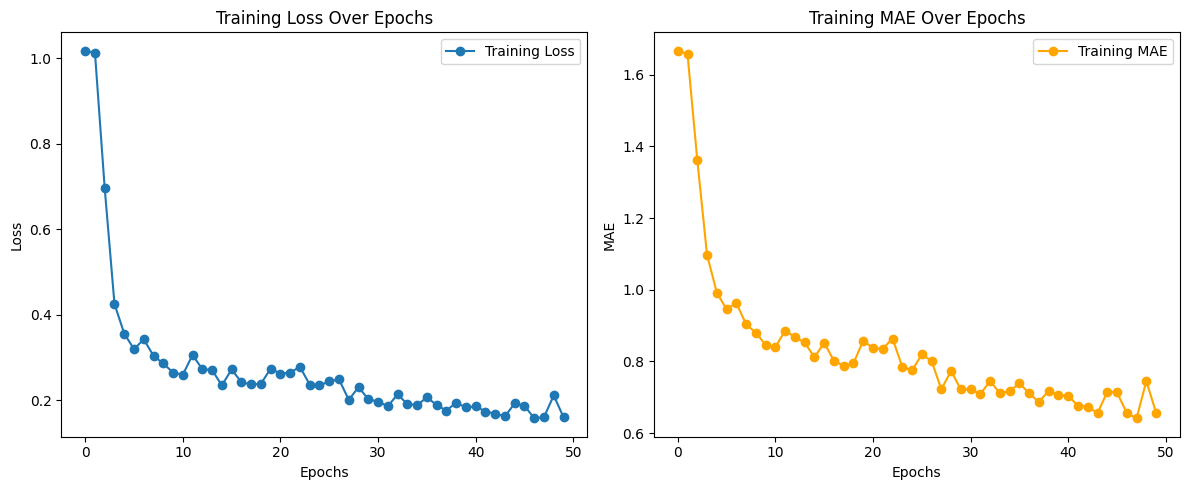

In [13]:
import matplotlib.pyplot as plt
training_loss =  [t.detach() for t in loss]
Training_loss = [t.item() for t in training_loss]
# Sample data (replace these with your actual data)
epochs = epoch # 1 to 50
 
training_mae = mae

# Create plots
plt.figure(figsize=(12, 5))

# Plot for training loss
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, Training_loss, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for training MAE
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs, training_mae, label='Training MAE', color='orange', marker='o')
plt.title('Training MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()